# Introduction

We need to convert the file type and reproject our Snow Water Equivalent data into the format accepted by Google Earth Engine.

In [81]:
# Imports
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import exists, join
import pandas as pd
from PIL import Image
import re
import rioxarray
import subprocess
import urllib
import xarray as xr

# Silence warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# EASE Grids Map Projection to WGS84

The GlobSnow data product is produced by the European Space Agency as a HDF4 file. Plotting the SWE from the original file using xarray shows a Northern Hemisphere, Lambert Azimuthal projection.

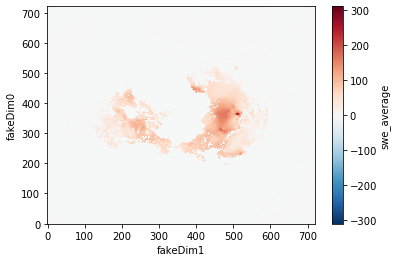

In [89]:
f = "../data/01/GlobSnow_SWE_L3B_monthly_201601_v2.0.hdf"
data = xr.open_dataset(f)
data.swe_average.plot()

We would like to reproject this to WGS84. Unfortunately, if we look at the xarray dataset we see there are no latitude, longitude data variables. The metadata concerning the projection is missing. Without this projection information, GDAL does not know how to map the pixel coordinates to latitude and longitude. 

In [3]:
print(data)

<xarray.Dataset>
Dimensions:      (fakeDim0: 721, fakeDim1: 721, fakeDim2: 721, fakeDim3: 721)
Dimensions without coordinates: fakeDim0, fakeDim1, fakeDim2, fakeDim3
Data variables:
    swe_average  (fakeDim0, fakeDim1) float32 ...
    swe_maximum  (fakeDim2, fakeDim3) float32 ...
Attributes:
    Data content, field 1:        Monthly mean Snow Water Equivalent (mm)
    Data content, field 2:        Monthly maximum Snow Water Equivalent (mm)
    Sensor :                      SSM/I
    Data Date :                   yyyymmdd
    Processing Date:              yyyymmdd
    Coordinate system :           Equal-Area Scalable Earth Grid (EASE-Grid) ...
    Latitude range:               35N - 85N
    Longitude range:              180W - 180E
    Spatial Resolution :          25 X 25 sq.km
    Processing software name:     FMI assimilation algorithm (Pullianen 2006)
    Processing software version:  v 2.0
    Processing Organisation:      Finnish Meteorological Institute
    Landmask :           

### Programmatically obtain projection data

The parameters of the grid can be found at the [National Snow & Ice Data Center](https://nsidc.org/ease/ease-grid-projection-gt). We wrote a class to obtain the projection data from the data provided on the NSIDC website. The EPSG and map coordinates of pixel corners must be manually provided to the GDAL translate utility. 

In [4]:
class EASE_Parameters(object):
    
    def __init__(self, version=1, hemisphere='Northern'):

        '''
        Retrieve CRS information from URL.
        
        :param version: The version number (1 or 2) of the grid
        :param hemisphere: The hemisphere of interest (Northern or Southern)
        '''
        # Set the grid name using the supplied version number
        self.version = version
        grid_name = {
            1: 'EASE-Grid',
            2: 'EASE-Grid 2.0'
        }
        # Validate user input
        try:
            self.grid = grid_name[self.version]
        except KeyError:
            raise UserWarning('You must choose between version 1 and version 2.')
        
        # Validate the hemisphere input
        self.hemisphere = hemisphere
        if self.hemisphere.lower() not in ['northern', 'southern']:
            raise UserWarning('You must chose between the Northern and Southern hemisphere.')
 
        self.url = "https://nsidc.org/ease/ease-grid-projection-gt"
        self._table_number = -2
        
    @property
    def table_number(self):
        return self._table_number
    
    @table_number.setter
    def table_number(self, n):
        self._table_number = n

    @property
    def table(self):
        '''
        Return the dataframe for the grid and resolution of interest.
        Rather than pass resolution as a parameter, select the table number from
        
        '''
        tables = pd.read_html(self.url)
        num_tables = len(tables) -1
        if abs(self._table_number) > num_tables:
            raise UserWarning(f'There are only {num_tables} tables, please select a valid table number.')
        
        df = tables[self._table_number]
        # The Grid Name column name varies over tables, use column number
        return df[(df[df.columns[0]]==self.grid) & (df['Projection'].str.contains(self.hemisphere, case=False))]
    
    @property
    def epsg(self):
        '''
        Return the EPSG code corresponding to the CRS. 
        '''
        proj = self.table['Projection'].item()
        pattern = re.compile('EPSG: \d{4}')
        epsg = re.search(pattern, proj)[0]
        return epsg.replace(' ', '')
    
    @property
    def num_cols(self):
        '''
        Return the number of columns in the grid.
        '''
        return self.table['Number of Columns'].item()

    @property
    def num_rows(self):
        '''
        Return the number of rows in teh grid.
        '''
        return self.table['Number of Rows'].item()
    
    @property
    def grid_size(self):
        '''
        Grid cell area is reported as a string {number} {unit} x {number} {unit}.
        Parse the string and take the first number as the size
        '''
        return float(self.table['Grid Cell Area'].item().split(' ')[0].replace(',',''))
    
    # TODO: Debug key error 
    @property
    def ulx(self):
        try:
            return self.table['x-axis map coordinate of the outer edge of the upper-left pixel'].item()
        except KeyError:
            return self.table[self.table.columns[-2]].item()
                
    @property
    def uly(self):
        try:
            return self.table['y-axis map coordinate of the outer edge of the upper-left pixel'].item()
        except KeyError:
            return self.table[self.table.columns[-1]].item()
    
    @property
    def lrx(self):
        '''
        Return the lower right x coord by multiplying the grid size by the number of columns.
        '''
        return self.ulx + self.grid_size*self.num_cols
    
    @property 
    def lry(self):
        '''
        Return the lower right x coord by multiplying the grid size by the number of rows.
        '''
        return self.uly - self.grid_size*self.num_rows
    



### Convert HDF file to TIF file
When GDAL is given the projection information, it can be used to convert to a GeoTiff file.




In [85]:
def download_globsnow(directory):
    '''
    Download all available data.
    '''
    for year in range(1997, 2017):
        for month in range(1, 13):
            mon = "{0:0=2d}".format(month)
            filename = f"GlobSnow_SWE_L3B_monthly_{year}{mon}_v2.0.hdf"
            folder = join(directory, mon)
            if not exists(folder):
                os.makedirs(folder)
            if not exists(join(folder, filename)):
                url = f"http://www.globsnow.info/swe/archive_v2.0/{year}/L3B_monthly_SWE_HDF/{filename}"
                try:
                    urllib.request.urlretrieve(url, join(folder, filename))
                except:
                    continue

# File conversion function 
def translate_globsnow(directory, month):
    '''
    Add meta data to the raw file and convert to gdal virtual format.
    '''
    # Obtain CRS information
    param = EASE_Parameters()
    epsg = param.epsg
    ulx, uly, lrx, lry = param.ulx, param.uly, param.lrx, param.lry
    
    # Find files that match this pattern
    pattern = re.compile("(GlobSnow_SWE_L3B_monthly_(\d{4})(\d{2})_v2.0.hdf)")
    folder = join(directory, month)
    for f in glob(join(folder, '*.hdf')):
        match = re.search(pattern, f)
        if match is not None:
            # Create output filename from input filename
            input_file, year, month = match.groups()
            output_file = f"GlobSnow_SWE_Average_{year}_{month}.vrt"
            bash_cmd = (
                f"gdal_translate -of VRT -a_nodata -1 "
                f"-a_srs {epsg} -a_ullr {ulx} {uly} {lrx} {lry} "
                f"HDF4_SDS:UNKNOWN:\"{input_file}\":0 {output_file}"
            )
            subprocess.Popen(bash_cmd, cwd=folder, shell=True, executable='/bin/bash')

def convert_globsnow(directory, month):
    '''
    Convert .vrt to a .tif file.
    '''
    pattern = re.compile("GlobSnow_SWE_Average_\d{4}_\d{2}.vrt")
    folder = join(directory, month)
    for f in glob(join(folder, '*.vrt')):
        match = re.search(pattern, f)
        if match is not None:
            input_file = match[0]
            output_file = input_file.replace('.vrt', '.tif')
            bash_cmd = (
                f"gdalwarp -of GTiff "
                f"-t_srs EPSG:4326 -r cubic "
                f"{input_file} {output_file}"
            )
            subprocess.Popen(bash_cmd, cwd=folder, shell=True, executable='/bin/bash')
     
    
def plot(filename):
    '''
    Plot image.
    '''
    im = Image.open(filename)
    plt.imshow(im)

Replotting the data we can see it has been reprojected.

In [ ]:
# Run code 
download_globsnow("../data")
for month in ["{0:0=2d}".format(m) for m in range(1,13)]:
    translate_globsnow("../data", month)
    convert_globsnow("../data", month)
plot("../data/GlobSnow_SWE_Average_2016_01.tif")